# Introduction

This notebook demonstrates the application of the [hydroTrends](https://github.com/skalevag/hydroTrends) **trendAnalysis** and **plotting** module. For an example of a more extensite application of the tool see [Skålevåg & Vormoor, 2021](https://doi.org/10.22541/au.161319077.75813136/v1).

# Setup and data

## Modules

In [1]:
# modules
from tools.trendAnalysis import timeSeriesStack,trendArray
import numpy as np
import pandas as pd
from tools.old.HTfunctions import readRunoff
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl

## Metadata table

In [2]:
dataDIR = "~/Documents/UP WHK/HydroTrends/Data" #local filepath

metadataFull = pd.read_csv(Path(dataDIR).joinpath("updated_stationselection.csv"),index_col=0)

#stationList = [2000011,2200022,2800007]
#metadata = metadataFull[metadataFull["snumber"].isin(stationList)]

# for this demonstration, we will look at only those catchments which have time series starting before 1900
metadata = metadataFull[metadataFull["start.yr"]<1900]

A metadata table is necessary for when using the tool, because it is needed to sort the catchments in the right order. In this demonstration, we will sort by altitude (median catchment altitute). 

In [3]:
metadata

,snumber,regine,main,name,stnr,start.yr,end.yr,missing.yr,areal,altitude,utm.e,runoff.region,lon,lat,BREPRO,station.order,seNorge,missingData30yr
42,6200005,62,5,Bulken (Vangsvatnet),62.500,1892,2014,0,1092.04,867.0,24487.79,vestlandet,6.291809,60.629297,0.39,27,1,0.0
13,200145,2,145,BaattstO,2.145,1896,2012,0,11212.84,1139.0,247417.27,ostlandet,10.277532,61.333385,3.00,41,1,0.0
34,200604,2,604,Elverum,2.604,1871,2013,0,15451.76,817.0,313303.90,ostlandet,11.560652,60.874212,0.00,20,1,0.0
36,31100004,311,4,Femundsenden (Femunden),311.400,1896,2013,0,1794.03,782.0,339350.00,ostlandet,11.940043,61.919961,0.00,18,1,0.0
9,2200004,22,4,KjOlemo,22.400,1896,2013,0,1757.70,560.0,60352.10,sorlandet,7.527672,58.120237,0.00,16,1,0.0
17,2000003,20,3,Flaksvatn,20.300,1899,2013,0,1780.66,354.0,102366.62,sorlandet,8.203061,58.330464,0.00,8,1,0.0


Next we will sort the catchments by altitude, so that the highest catchments appear first.

In [4]:
metadata = metadata.sort_values("altitude",ascending=False)
metadata

,snumber,regine,main,name,stnr,start.yr,end.yr,missing.yr,areal,altitude,utm.e,runoff.region,lon,lat,BREPRO,station.order,seNorge,missingData30yr
13,200145,2,145,BaattstO,2.145,1896,2012,0,11212.84,1139.0,247417.27,ostlandet,10.277532,61.333385,3.00,41,1,0.0
42,6200005,62,5,Bulken (Vangsvatnet),62.500,1892,2014,0,1092.04,867.0,24487.79,vestlandet,6.291809,60.629297,0.39,27,1,0.0
34,200604,2,604,Elverum,2.604,1871,2013,0,15451.76,817.0,313303.90,ostlandet,11.560652,60.874212,0.00,20,1,0.0
36,31100004,311,4,Femundsenden (Femunden),311.400,1896,2013,0,1794.03,782.0,339350.00,ostlandet,11.940043,61.919961,0.00,18,1,0.0
9,2200004,22,4,KjOlemo,22.400,1896,2013,0,1757.70,560.0,60352.10,sorlandet,7.527672,58.120237,0.00,16,1,0.0
17,2000003,20,3,Flaksvatn,20.300,1899,2013,0,1780.66,354.0,102366.62,sorlandet,8.203061,58.330464,0.00,8,1,0.0


From the sorted metadata table, get the catchment ID numbers that will define the order by which the following arrays will be sorted.

In [5]:
print("Altitudes:",list(metadata["altitude"]))
ids = list(metadata["snumber"])
print("Catchment IDs:",ids)

Altitudes: [1139.0, 867.0, 817.0, 782.0, 560.0, 354.0]
Catchment IDs: [200145, 6200005, 200604, 31100004, 2200004, 2000003]


## Streamflow data

Import the streamflow data and organise it into a dictionary, where the keys are the catchment ID numbers.

In [6]:
data = {}
for c in ids:
    data[c] = readRunoff(c,folder=Path(dataDIR).joinpath("runoff"))

# timeSeriesStack

In [7]:
help(timeSeriesStack)

Help on class timeSeriesStack in module tools.trendAnalysis:

class timeSeriesStack(builtins.object)
 |  This class takes data from a dictionary of time series data, 
 |  extracts the data for chosen years and applies moving average, 
 |  and finally stacks the data in a 3D-array, sorted by a specific 
 |  attribute in a metadata table.
 |  
 |  Attributes
 |  ----------
 |  array: numpy.array
 |      3D-array containing the moving average filtered values for the specified time period
 |      shape: (day of year, years, number of catchments/stations)
 |  metadata: pd.DataFrame
 |      sorted metadata table
 |  variable: str
 |      variable name
 |  unit: str
 |      unit of variable to be stacked
 |  sortAttributeValues: list
 |      sorted list of values of attribute used to sort dataframe
 |  IDs: list
 |      sorted list of ID numbers
 |  movingAverageDays: int
 |      number of days in moving average filter (e.g. 5,10 or 30)
 |  sortedBy: str
 |      attribute/variable used to sor

## Initialise timeSeriesStack

When inisialising the timeSeriesStack object, a number of arguments must be defined (see docstring above).

In [8]:
ts = timeSeriesStack(data=data,
                     variable="streamflow",
                     unit="$m^3\ s^{-1}$",
                     metadata=metadata,
                     sortBy="altitude",
                     sortAttributeUnit="m a.s.l.",
                     IDcol="snumber",
                     MA=10,
                     startYear=1901,
                     endYear=2000)

The resulting object contains a 3D array of moving average filtered values, for the speficied year, with the shape (day of year, years, number of catchments/stations).

In [9]:
ts.array.shape

(365, 100, 6)

## Climatology
Based on the timeSeriesStack create an array with climatology:

In [10]:
ts.makeClimatology()

array([[ 76.54774101,  76.53461168,  76.40623342, ...,  79.0367437 ,
         78.36487753,  77.91884658],
       [ 25.677742  ,  24.93491746,  24.28903017, ...,  26.75737709,
         26.25469796,  25.81550047],
       [ 99.32981792,  99.61573737,  99.89513883, ..., 100.82267498,
        100.64567626, 100.51893076],
       [ 12.70998525,  12.6606873 ,  12.60358653, ...,  13.01165528,
         12.94918685,  12.89062679],
       [ 73.04693055,  71.79106774,  70.61809453, ...,  75.76229321,
         75.15627917,  74.03872626],
       [ 50.3294171 ,  49.30011315,  48.27112565, ...,  52.41592152,
         52.03514629,  51.22178089]])

The climatology array is automatically saved as an attribute of the timeSeriesStack object.

In [11]:
ts.climatology

array([[ 76.54774101,  76.53461168,  76.40623342, ...,  79.0367437 ,
         78.36487753,  77.91884658],
       [ 25.677742  ,  24.93491746,  24.28903017, ...,  26.75737709,
         26.25469796,  25.81550047],
       [ 99.32981792,  99.61573737,  99.89513883, ..., 100.82267498,
        100.64567626, 100.51893076],
       [ 12.70998525,  12.6606873 ,  12.60358653, ...,  13.01165528,
         12.94918685,  12.89062679],
       [ 73.04693055,  71.79106774,  70.61809453, ...,  75.76229321,
         75.15627917,  74.03872626],
       [ 50.3294171 ,  49.30011315,  48.27112565, ...,  52.41592152,
         52.03514629,  51.22178089]])

## Hydrographs for individual catchments using quickplot

Using the quickplot function, the hydrographs for all catchments are plotted.

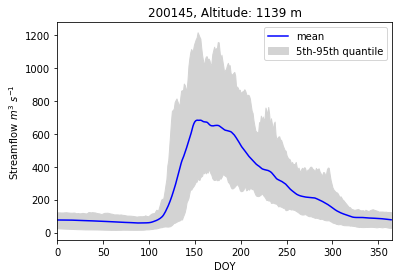

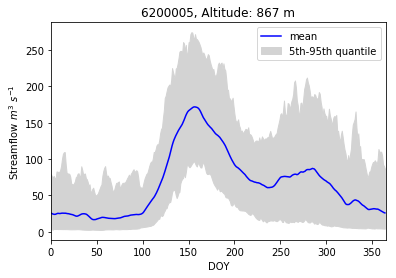

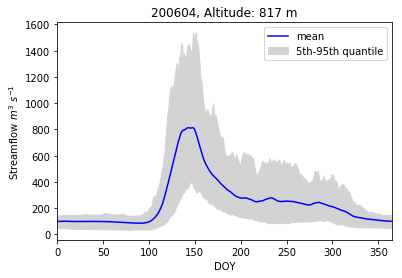

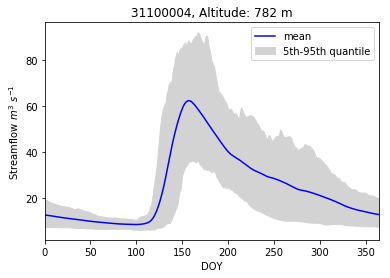

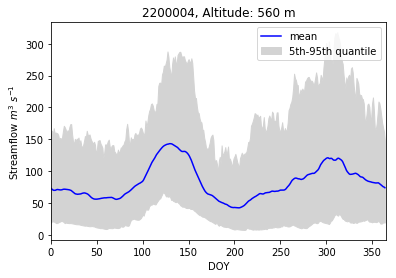

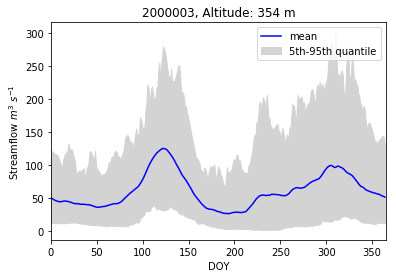

In [12]:
ts.quickplot()

## Raster hydrographs

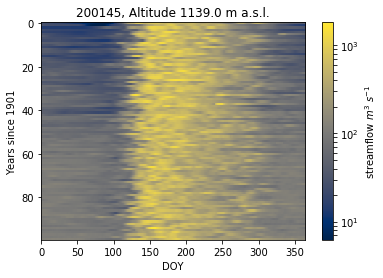

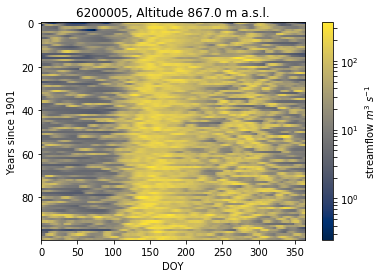

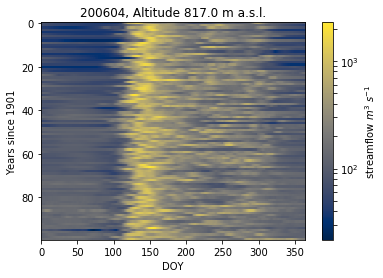

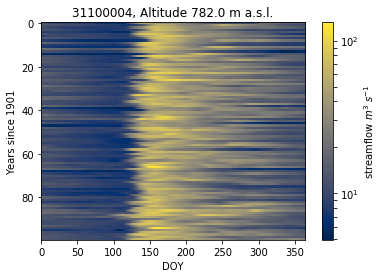

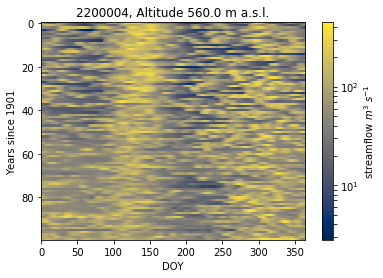

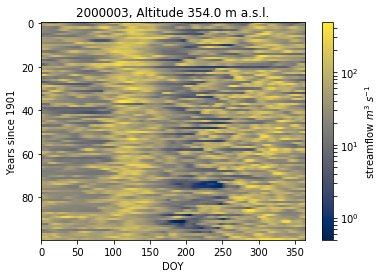

In [13]:
ts.rasterHydrograph()

# trendArray
Once all the data and metadata is in the timeSeriesStack object, the trendArray can be initialised.

In [14]:
help(trendArray)

Help on class trendArray in module tools.trendAnalysis:

class trendArray(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, tsStack)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fieldSign(self, alpha)
 |  
 |  mag(self, method='theil-sen', change='abs', applyPrewhitening=True)
 |      Calculates the trend magnitudes from the predetermined parameters.
 |      
 |      Parameters
 |      ----------
 |      method: str
 |          "theil-sen"
 |      change: str
 |          "abs"   absolute change
 |          "rel"   relative change
 |  
 |  saveToFile(self, name, DIR='./')
 |      Save the trend arrays to file.
 |  
 |  sign(self, method='mann-kendall', alpha=0.1, applyPrewhitening=True)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the objec

In [15]:
# initialise trendArray object
ta = trendArray(ts)
# calculate trend magnitudes
ta.mag(method="theil-sen",change="rel")
# calculate trend significant
ta.sign("mann-kendall")

# Saving the results to file

In [16]:
help(ts.saveToFile)

Help on method saveToFile in module tools.trendAnalysis:

saveToFile(name, DIR='./') method of tools.trendAnalysis.timeSeriesStack instance
    Saves the array and sorted metadata table to file.
    
    Parameters
    ----------
    name: str
        the name of 
    DIR: str
        path to directory where data is to be saved



The results can be saved to files. All files are tagged with the provided **name**, and any relevant information is added automatically, based on attributes from the timeSeriesStack and trendArray objects.

In [17]:
name="demo"
# save data and results to files
ts.saveToFile(name)
ta.saveToFile(name)

In [18]:
for f in list(Path("./").glob("*demo_*")): print(f)

demo_streamflow_sortedByaltitude_10MA_1901-2000_trendMagnitudes.npy
demo_streamflow_sortedByaltitude_10MA_1901-2000_stackedArray.npy
demo_streamflow_sortedByaltitude_10MA_1901-2000_metadata.csv
demo_streamflow_sortedByaltitude_10MA_1901-2000_climatology.npy
demo_streamflow_sortedByaltitude_10MA_1901-2000_trendSignificance.npy


# Plotting (in development)

In [19]:
from tools.plotting import plotTrendArray

In [20]:
help(plotTrendArray)

Help on function plotTrendArray in module tools.plotting:

plotTrendArray(ta, factor=10, cmap='RdBu', plotSignificance=True, colorbarLimit=0.8)
    Plot trend array.
    
    Parameters
    ----------
    ta: trendArray object
    factor: int
        default: 10
    cmap: str
        default: "RuBu
        name of colormap
        should be a diverging colomap to show positive and negative trends
    plotSignificance: boolean
        default: True
    colorbarLimit: float
        default: 0.8



## Trend significance and magnitudes plot

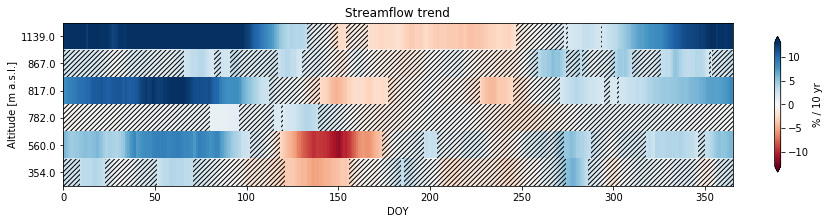

In [21]:
plotTrendArray(ta)

## Trend magnitues plot

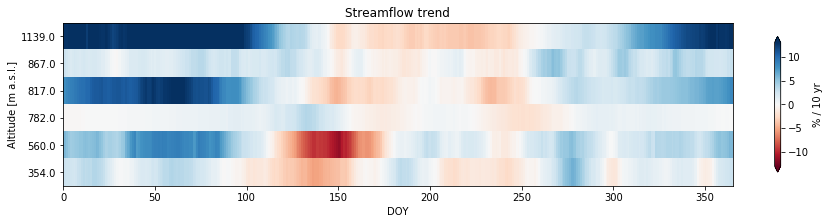

In [22]:
plotTrendArray(ta,plotSignificance=False)

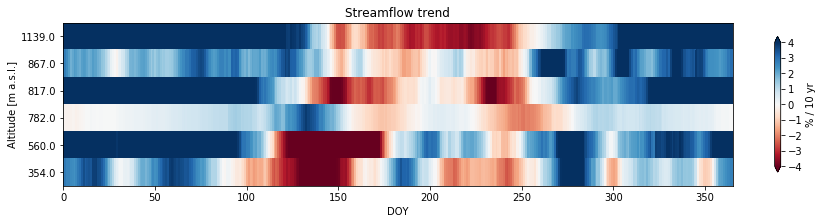

In [23]:
plotTrendArray(ta,plotSignificance=False,colorbarLimit=0.5)

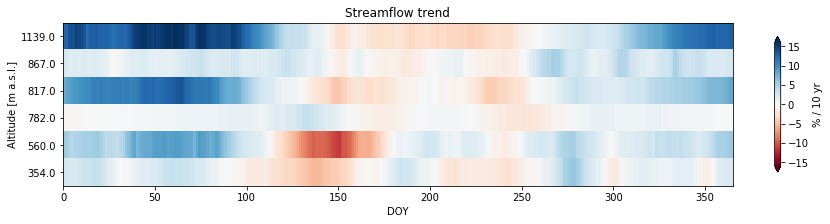

In [24]:
plotTrendArray(ta,plotSignificance=False,colorbarLimit=1)